# Build Autoencoder in Keras

In this tutorial, we will answer some common questions about autoencoders, and we will cover code examples of the following models:

    - a deep convolutional autoencoder
    - an image denoising model
    - a sequence-to-sequence autoencoder
    - a variational autoencoder

**Note: all code examples have been updated to the Keras 2.0 API on March 14, 2017. You will need Keras version 2.0.0 or higher to run them.**

In [1]:
import keras
print('Your keras version is: ', keras.__version__)

Your keras version is:  2.0.8


Using TensorFlow backend.


## Convolutional autoencoder

Since our inputs are images, it makes sense to use [convolutional neural networks (convnets)](https://www.safaribooksonline.com/library/view/deep-learning/9781491924570/ch04.html) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders -- they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.


To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

Let's train this model for 50 epochs. 

In [3]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 56s - loss: 0.2356 - val_loss: 0.1856
Epoch 2/50
60000/60000 [==============================] - 65s - loss: 0.1716 - val_loss: 0.1639
Epoch 3/50
60000/60000 [==============================] - 66s - loss: 0.1538 - val_loss: 0.1473
Epoch 4/50
60000/60000 [==============================] - 61s - loss: 0.1420 - val_loss: 0.1368
Epoch 5/50
60000/60000 [==============================] - 62s - loss: 0.1337 - val_loss: 0.1307
Epoch 6/50
60000/60000 [==============================] - 62s - loss: 0.1283 - val_loss: 0.1242
Epoch 7/50
60000/60000 [==============================] - 62s - loss: 0.1248 - val_loss: 0.1216
Epoch 8/50
60000/60000 [==============================] - 61s - loss: 0.1224 - val_loss: 0.1205
Epoch 9/50
60000/60000 [==============================] - 61s - loss: 0.1201 - val_loss: 0.1179
Epoch 10/50
60000/60000 [==============================] - 61s - loss: 0.1185 - val_lo

The model converges to a loss of 0.099, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# utility function for showing images
def show_imgs(x_test, decoded_imgs=None, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

input (upper row)
decoded (bottom row)


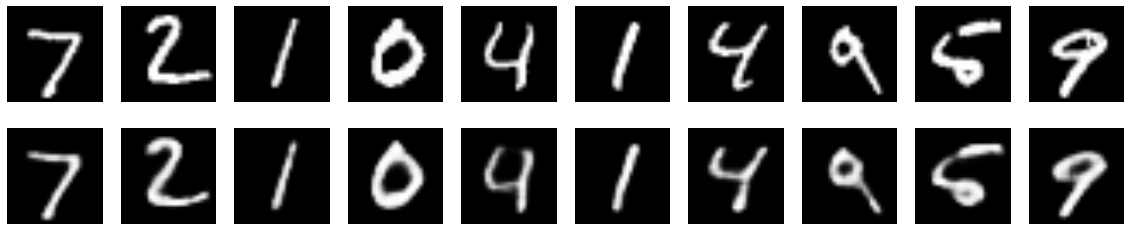

In [10]:
decoded_imgs = autoencoder.predict(x_test)
print("input (upper row)\ndecoded (bottom row)")
show_imgs(x_test, decoded_imgs)

#### YOUR TURN HERE

Q: Comparing above results to the results in part0, is it much improved?

A: (double click to fill in your answer here)

## Image Denoising Autoencoder

As discussed in part0, image (data) denoising is one of the most important functions of autoencoders. Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [11]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's what the noisy digits look like:

Noisy digits look like below: 


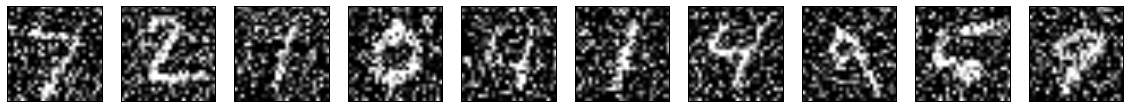

In [13]:
print("Noisy digits look like below: ")
show_imgs(x_test_noisy)

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [14]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Below code block will take 30+ mins to run.

**NOTE: I would suggest you skip next step and the step below it *in class*, and resume on it on your own time so you can follow along.**

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 105s - loss: 0.1975 - val_loss: 0.1282
Epoch 2/100
60000/60000 [==============================] - 115s - loss: 0.1257 - val_loss: 0.1213
Epoch 3/100
60000/60000 [==============================] - 114s - loss: 0.1166 - val_loss: 0.1119
Epoch 4/100
60000/60000 [==============================] - 114s - loss: 0.1122 - val_loss: 0.1092
Epoch 5/100
60000/60000 [==============================] - 115s - loss: 0.1091 - val_loss: 0.1067
Epoch 6/100
60000/60000 [==============================] - 114s - loss: 0.1070 - val_loss: 0.1049
Epoch 7/100
60000/60000 [==============================] - 114s - loss: 0.1057 - val_loss: 0.1040
Epoch 8/100
60000/60000 [==============================] - 114s - loss: 0.1043 - val_loss: 0.1023
Epoch 9/100
60000/60000 [==============================] - 117s - loss: 0.1035 - val_loss: 0.1029
Epoch 10/100
60000/60000 [==============================] - 116s - l

noisy (upper row)
decoded (bottom row)


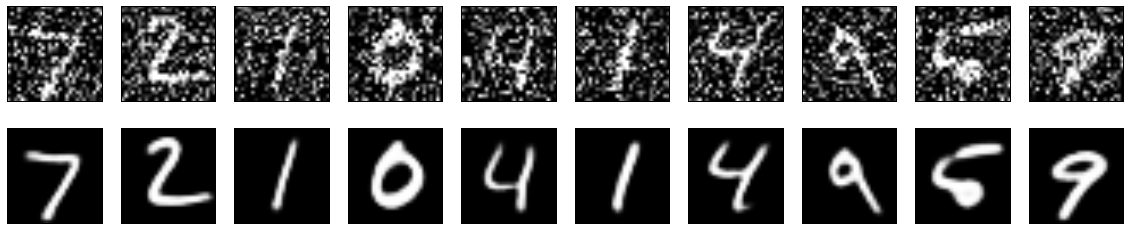

original


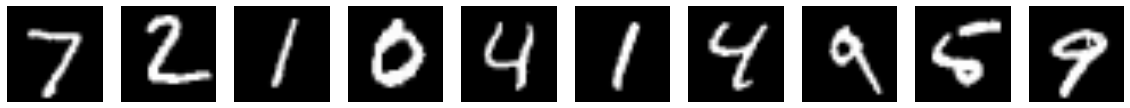

In [17]:
decoded_imgs = autoencoder.predict(x_test)
print("noisy (upper row)\ndecoded (bottom row)")
show_imgs(x_test_noisy, decoded_imgs)
print("original")
show_imgs(x_test)

## A Sequence-to-Sequence Autoencoder

Above autoencoders are cute and interesting - but can we get more practical than compressing and denoising images?

Have you ever wondered how agents like **Google Translate** works? Autoencoder can do something like that - now it sounds more interesting, doesn't it?

As discussed in the lecture, Recurrent Neural Networks (RNN) can capture sequential information - hence, the encoder-decoder model provides a pattern for using RNN layers (or in particular, LSTM) to address challenging sequence-to-sequence prediction problems, such as **machine translation**.

After completing this tutorial, you will know:

    - How to correctly define a sophisticated encoder-decoder model in Keras for sequence-to-sequence prediction.
    - How to define a contrived yet scalable sequence-to-sequence prediction problem that you can use to evaluate the encoder-decoder LSTM model.
    - How to apply the encoder-decoder LSTM model in Keras to address the scalable integer sequence-to-sequence prediction problem.

We already know that we can embed words as (elements in) vectors, and it is difficult to find a non English language that we are all proficient in - so let's play with some embedded words. In this case, we are using numbers/vectors to represent words, so we do not have to play with some foreign language.

*As an example, vector X = [1, 267, 5, 38] represents sentence "the summer is here".*

Let’s get started!
### Build an RNN-based Encoder-Decoder Model in Keras

In [12]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

The encoder-decoder model is a way of organizing recurrent neural networks for sequence-to-sequence prediction problems.

It was originally developed for **machine translation** problems, although it has proven successful at related **sequence-to-sequence prediction** problems such as **text summarization** and **question answering**.

**PROJECT HINT**: more interests have been spent on using sequence-to-sequence prediction on time-series data.

The approach involves two **recurrent neural networks**, one to encode the source sequence, called the **encoder**, and a second to decode the encoded source sequence into the target sequence, called the **decoder**. But you already knew them, don't you?

The Keras deep learning Python library provides an example of how to implement the encoder-decoder model for machine translation ([lstm_seq2seq.py](https://github.com/fchollet/keras/blob/master/examples/lstm_seq2seq.py)) described by the libraries creator in the post: [“A ten-minute introduction to sequence-to-sequence learning in Keras.”](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

Using the code in that example as a starting point, here we will develop a generic function to define an encoder-decoder recurrent neural network. 

The function needs to take 3 arguments, as follows:

- n_input: The cardinality of the input sequence, e.g. number of features, words, or characters for each time step.
- n_output: The cardinality of the output sequence, e.g. number of features, words, or characters for each time step.
- n_units: The number of cells/**neurons**to create in the encoder and decoder models, e.g. 128 or 256.

The function then creates and returns 3 models, as follows:

- train: Model that can be trained given source, target, and shifted target sequences.
- inference_encoder: Encoder model used when making a prediction for a new source sequence.
- inference_decoder Decoder model use when making a prediction for a new source sequence.

Below is this function named **define_models()**.

In [4]:
def define_models(n_input, n_output, n_units):
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    # return all models
    return model, encoder_model, decoder_model

The model is trained given source and target sequences where the model takes both the **source** and a *shifted* version of the **target** sequence as input and predicts the **whole target** sequence.

For example, one source sequence may be [1,2,3] and the target sequence [4,5,6]. The inputs and outputs to the model during training would be:

The model is intended to be called recursively when generating target sequences for new source sequences.

The source sequence is encoded and the target sequence is generated one element at a time, using a “start of sequence” character such as ‘_’ to start the process. Therefore, in the above case, the following input-output pairs would occur during training:

Here you can see how the recursive use of the model can be used to build up output sequences.

During *prediction*, the **inference_encoder model** is used to encode the input sequence *once* which returns states that are used to **initialize the inference_decoder model**. From that point, the **inference_decoder model** is used to **generate predictions step by step**.

The function below named **predict_sequence()** can be used after the model is trained to generate a target sequence given a source sequence.

In [5]:
# generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    return array(output)

This function takes 5 arguments as follows:

- infenc: Encoder model used when making a prediction for a new source sequence.
- infdec: Decoder model use when making a prediction for a new source sequence.
- source: Encoded source sequence.
- n_steps: Number of time steps in the target sequence.
- cardinality: The cardinality of the output sequence, e.g. the number of features, words, or characters for each time step.

The function then returns a list containing the target sequence.



### Scalable Sequence-to-Sequence Problem

In this section, we define a contrived and scalable sequence-to-sequence prediction problem.

The source sequence is a series of randomly generated integer values, such as [20, 36, 40, 10, 34, 28], and the target sequence is a reversed pre-defined subset of the input sequence, such as the first 3 elements in reverse order [40, 36, 20].

**EXPLANATION**: if the original sequence is a word embedding in language X, we are doing a weird translation where foreign language Y actually takes the first three words in X and reverse them in order.

The length of the source sequence is configurable; so is the cardinality of the input and output sequence and the length of the target sequence.

We will use source sequences of 6 elements, a cardinality of 50, and target sequences of 3 elements.

**EXPLANATION**: every sentence in language X has 6 words, and every sentence in language Y has 3 words. This is a common practice in text analytics - if the sentence in X has more than 6 words, the 7th word and on will be pruned; if the sentence has less than 6 words, it will be padded to 6.

Below are some more examples to make this concrete.

Let’s start off by defining a function to generate a sequence of random integers.

We will use the value of **0** as the padding or start of sequence character, therefore it is reserved and we cannot use it in our source sequences. To achieve this, we will add 1 to our configured cardinality to ensure the one-hot encoding is large enough (e.g. a value of 1 maps to a ‘1’ value in index 1).

For example:

In [6]:
n_features = 50 + 1

We can use the randint() python function to generate random integers in a range between 1 and 1-minus the size of the problem’s cardinality. 

The generate_sequence() below generates a sequence of random integers.

Next, we need to create the corresponding output sequence given the source sequence.

To keep thing simple, we will select the first n elements of the source sequence as the target sequence and reverse them.

We also need a version of the output sequence shifted forward by one time step that we can use as the mock target generated so far, including the start of sequence value in the first time step. We can create this from the target sequence directly.

**EXPLANATION**: This is the step to create the shifted version of the target.

Now that all of the sequences have been defined, we can one-hot encode them, i.e. transform them into sequences of binary vectors. We can use the Keras built in to_categorical() function to achieve this.

We can put all of this into a function named get_dataset() that will generate a specific number of sequences that we can use to train a model.

Finally, we need to be able to decode a one-hot encoded sequence to make it readable again.

This is needed for both printing the generated target sequences but also for easily comparing whether the full predicted target sequence matches the expected target sequence. The one_hot_decode() function will decode an encoded sequence.

In [14]:
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

Running the example first prints the shape of the generated dataset, ensuring the 3D shape required to train the model matches our expectations.

The generated sequence is then decoded and printed to screen demonstrating both that the preparation of source and target sequences matches our intention and that the decode operation is working.

In [16]:
from random import randint
from numpy import array
from numpy import argmax
from keras.utils import to_categorical

# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(1, n_unique-1) for _ in range(length)]

# prepare data for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
    X1, X2, y = list(), list(), list()
    for _ in range(n_samples):
        # generate source sequence
        source = generate_sequence(n_in, cardinality)
        # define target sequence
        target = source[:n_out]
        target.reverse()
        # create padded input target sequence
        target_in = [0] + target[:-1]
        # encode
        src_encoded = to_categorical([source], num_classes=cardinality)
        tar_encoded = to_categorical([target], num_classes=cardinality)
        tar2_encoded = to_categorical([target_in], num_classes=cardinality)
        # store
        X1.append(src_encoded)
        X2.append(tar2_encoded)
        y.append(tar_encoded)
    return array(X1), array(X2), array(y)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

# configure problem
n_features = 50 + 1
n_steps_in = 6
n_steps_out = 3
# generate a single source and target sequence
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
print(X1.shape, X2.shape, y.shape)
print('X1=%s, X2=%s, y=%s' % (one_hot_decode(X1[0]), one_hot_decode(X2[0]), one_hot_decode(y[0])))

(1, 6, 51) (1, 3, 51) (1, 3, 51)
X1=[40, 44, 25, 2, 46, 31], X2=[0, 25, 44], y=[25, 44, 40]


We are now ready to develop a model for this sequence-to-sequence prediction problem.

###Encoder-Decoder LSTM for Sequence Prediction

In this section, we will apply the encoder-decoder LSTM model developed in the first section to the sequence-to-sequence prediction problem developed in the second section.

The first step is to configure the problem.

In [23]:
# configure problem
#### fill in here

# We want the cardinality as 50 - so we are generating numbers between 1 and 50
#### NOTE that in text analytics this is the size of our dictionary 
n_features = 50 + 1 

# We want 8 elements in X
n_steps_in = 6

# We want 4 elements in X
n_steps_out = 3

Next, we must define the models and compile the training model.

In [17]:
# define model
train, infenc, infdec = define_models(n_features, n_features, 128)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Next, we can generate a training dataset of 100,000 examples and train the model.

In [20]:
# generate training dataset
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
print(X1.shape,X2.shape,y.shape)
# train model
train.fit([X1, X2], y, epochs=1)

(100000, 6, 51) (100000, 3, 51) (100000, 3, 51)
Epoch 1/1
100000/100000 [==============================] - 80s - loss: 0.0451 - acc: 0.9939    


### YOUR TURN HERE

Please report the shapes of the **Source**, **Shifted Target**, and the **Target** datasets.

Double click here to enter your answer.

Once the model is trained, we can evaluate it. We will do this by making predictions for 100 source sequences and counting the number of target sequences that were predicted correctly. We will use the numpy array_equal() function on the decoded sequences to check for equality.

Next, the model is fit. You should see a progress bar and the run should take less than one minute on a modern multi-core CPU.

### YOUR TURN HERE
Please report and try to interpret the loss and accuracy from above model below.

Double click here to enter your answer.

Next, the model is evaluated and the accuracy printed. We can see that the model achieves 100% accuracy on new randomly generated examples.

In [21]:
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
    X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
    target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
    if array_equal(one_hot_decode(y[0]), one_hot_decode(target)):
        correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

Accuracy: 99.00%


Finally, we will generate some predictions and print the decoded source, target, and predicted target sequences to get an idea of whether the model is working as expected.

As you can see, 10 new examples are generated and target sequences are predicted. Again, we can see that the model correctly predicts the output sequence in each case and the expected value matches the reversed first 3 elements of the source sequences.

In [22]:
# spot check some examples
for _ in range(10):
    X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
    target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
    print('X=%s y=%s, yhat=%s' % (one_hot_decode(X1[0]), one_hot_decode(y[0]), one_hot_decode(target)))

X=[37, 45, 33, 8, 36, 47] y=[33, 45, 37], yhat=[33, 45, 37]
X=[27, 45, 42, 41, 20, 19] y=[42, 45, 27], yhat=[42, 45, 27]
X=[39, 8, 29, 36, 40, 43] y=[29, 8, 39], yhat=[29, 8, 39]
X=[35, 6, 5, 38, 27, 34] y=[5, 6, 35], yhat=[5, 6, 35]
X=[45, 15, 4, 23, 36, 40] y=[4, 15, 45], yhat=[4, 15, 45]
X=[29, 26, 8, 46, 39, 1] y=[8, 26, 29], yhat=[8, 26, 29]
X=[9, 25, 7, 41, 29, 48] y=[7, 25, 9], yhat=[7, 25, 9]
X=[37, 16, 36, 48, 50, 41] y=[36, 16, 37], yhat=[36, 16, 37]
X=[20, 14, 38, 45, 7, 33] y=[38, 14, 20], yhat=[38, 14, 20]
X=[10, 19, 17, 3, 38, 46] y=[17, 19, 10], yhat=[17, 19, 10]


### YOUR TURN HERE

Use the code provided above, randomly generate 200,000 source sequences (X), and 200 target sequences (Y) accordingly.

Each sequence in X should have 8 elements, each sequence in Y is the reverse of the latter 4 elements of X.

Train a new model to use new X to predict Y.

## Variantional Autoencoders (VAE)

VAE are very important autoencoders - we often use them to generate simulation data. Due to the time limit I cannot do this in class, but you can follow [this detailed tutorial](https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial) on building VAEs with image data.

## Additional Reading Materials

1. [How to Define an Encoder-Decoder Sequence-to-Sequence Model for Neural Machine Translation in Keras](https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/)

2. [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)